### Jose Dominguez
***Homework 0*** 

***Data***
- German Bank Dataset

***Readings***
- Fairness Definitions Explained
- Designing AI for All


***Null Hypthesis***  
This particular German Bank is not bias when assessing the credit risk of a customer or group. 

In [133]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [134]:
# importing dataset
german_bank = pd.read_csv("data/german_credit.csv")

In [135]:
# previewing data
german_bank.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,3-Feb,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good
3,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,male : married/widowed,none,...,unknown / no property,39,none,for free,3-Feb,unskilled - resident,3 or more,no,yes,good
4,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,male : married/widowed,none,...,car or other,38,bank,rent,3-Feb,unskilled - resident,0 to 2,no,yes,good


In [136]:
# analyze distribution of numeric values 
german_bank.describe()

,duration,amount,age
count,1000.000000,1000.00000,1000.00000
mean,20.903000,3271.24800,35.54200
std,12.058814,2822.75176,11.35267
min,4.000000,250.00000,19.00000
25%,12.000000,1365.50000,27.00000
50%,18.000000,2319.50000,33.00000
75%,24.000000,3972.25000,42.00000
max,72.000000,18424.00000,75.00000


In [137]:
# viewing type of get feature
german_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   object
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   object
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

### Visualizing Distribution of Catgorical & Numerical Values

Most of the features within the gender_bank DataFrame are categorical values. With this we will like to see the distribution of each feature and its unique values. We will also look at the distribution of the numercial values.

In [138]:
# function to plot pie charts for categorical values and histrograms for numerical values
# all visuals will export to a pdf to use later
def plot_dist(df): 
    with PdfPages(r'data/export.pdf') as export_pdf:
        for col in df.columns:
            if df[col].dtype == "O":
                values = df[col].unique()
                counts = df[col].value_counts()
                # pie chart of categorical value distribution
                plt.figure(figsize=[10, 10])
                plt.pie(counts, labels = values, autopct='%1.0f%%')
                plt.legend(title = col, loc='upper right',labels=values)
                export_pdf.savefig()
                plt.show()
                plt.close()
            elif df[col].dtype == "int64":
                # histogram of numerical distibution
                df.hist(column=[col],figsize=[10, 8])
                export_pdf.savefig()
                plt.show()
                plt.close()

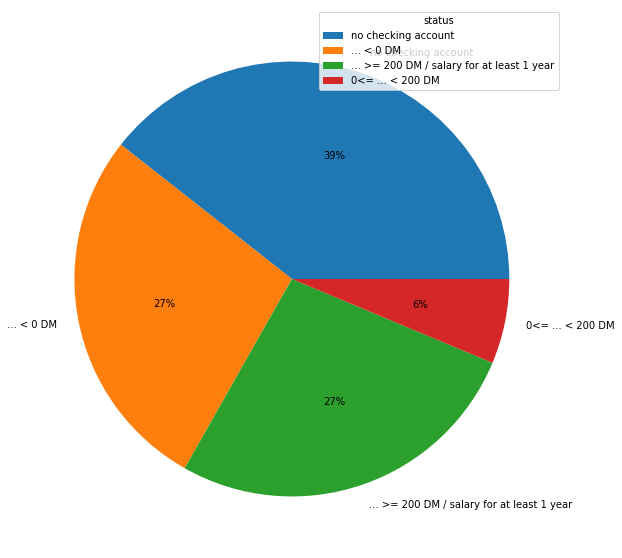

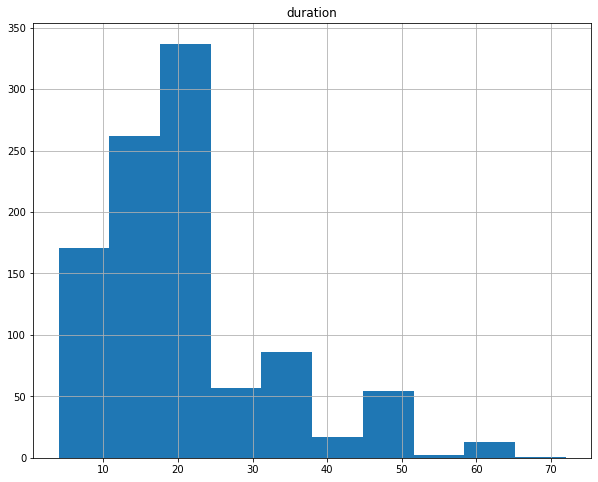

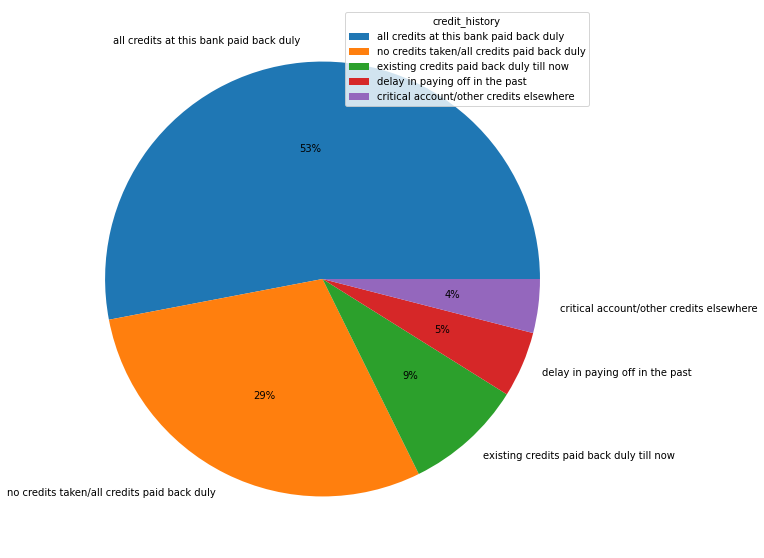

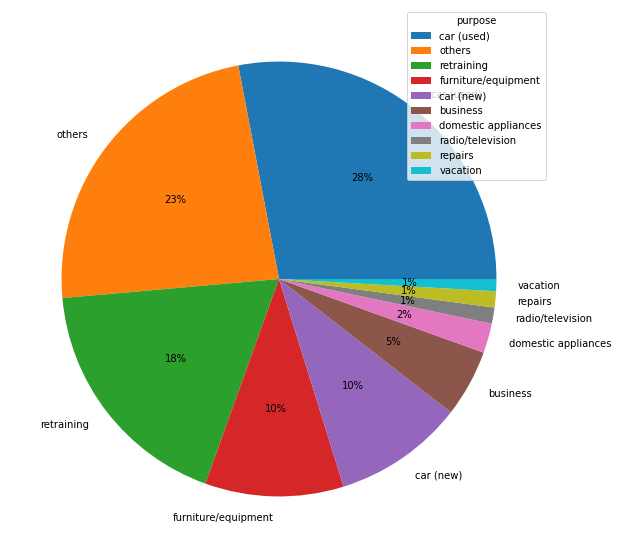

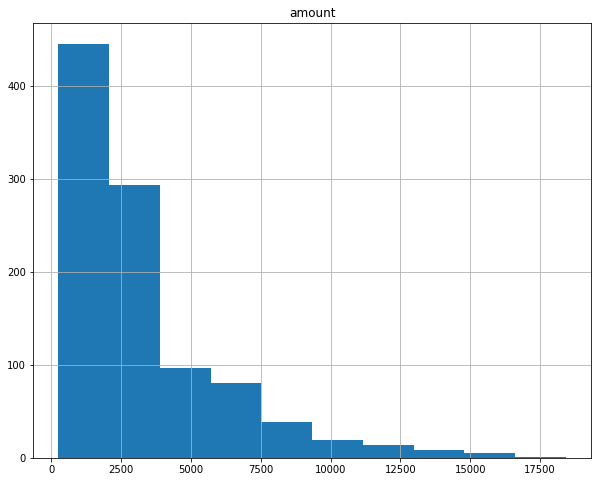

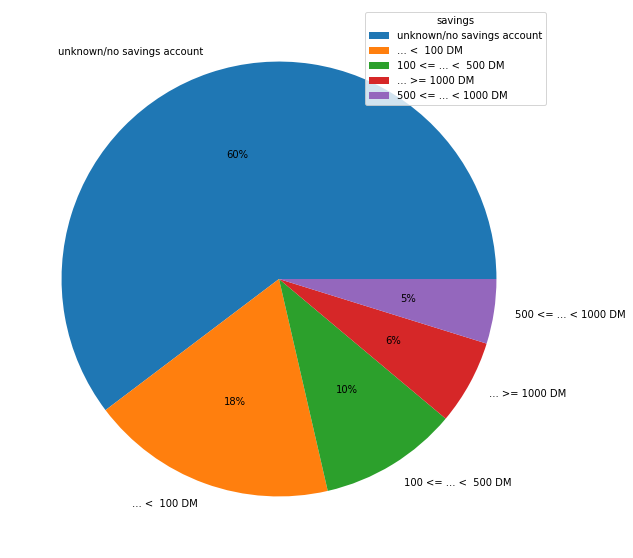

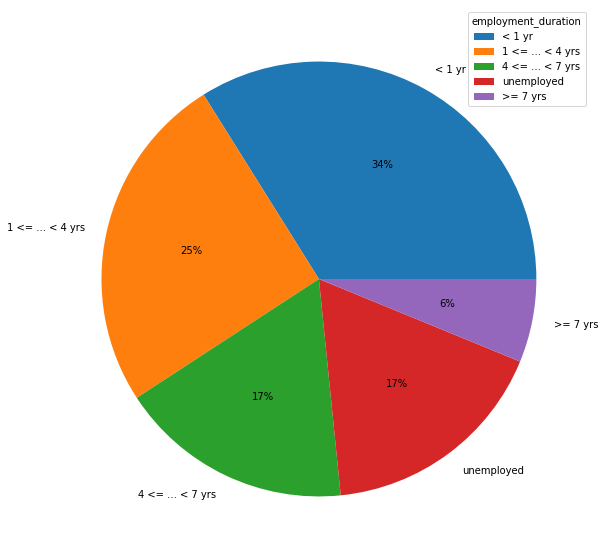

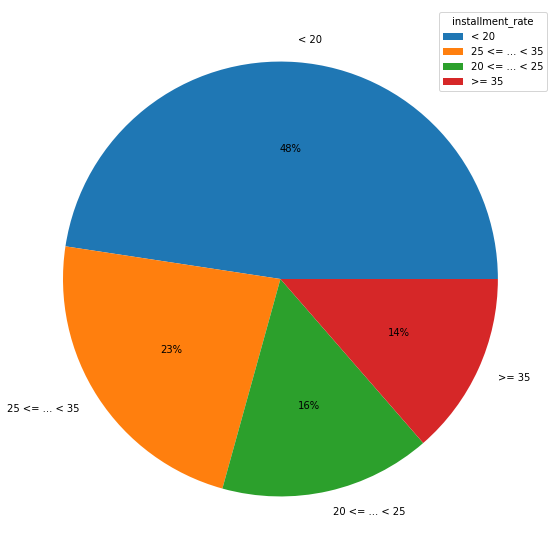

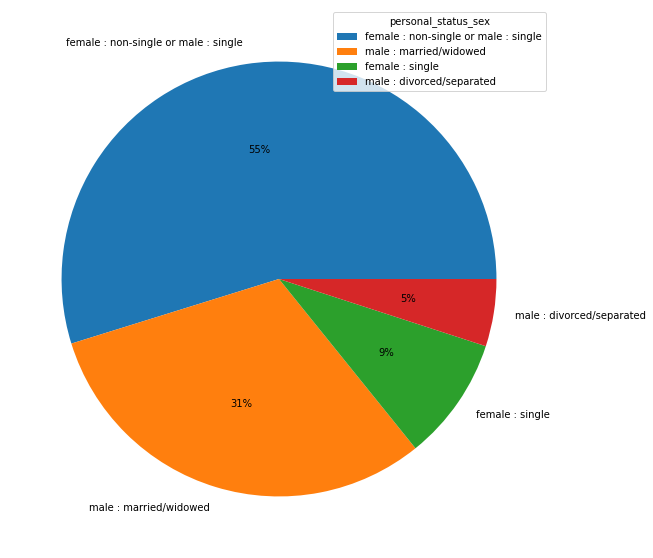

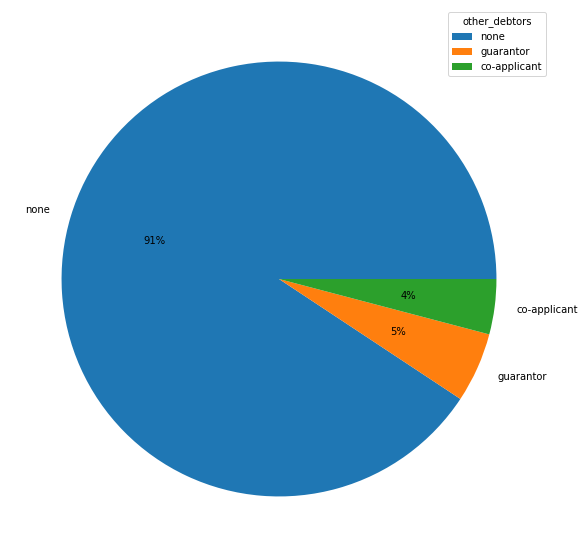

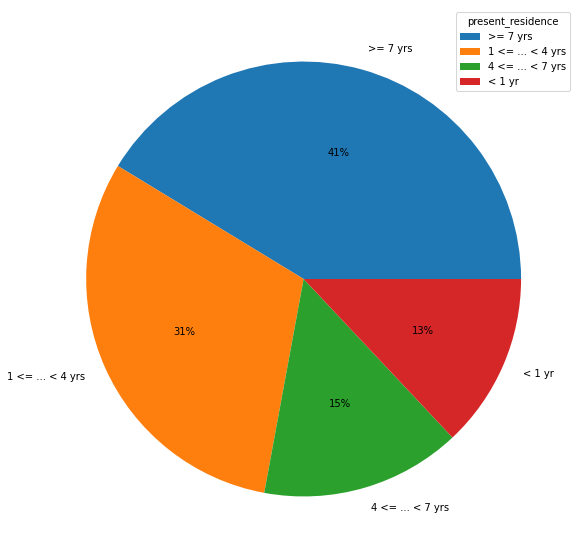

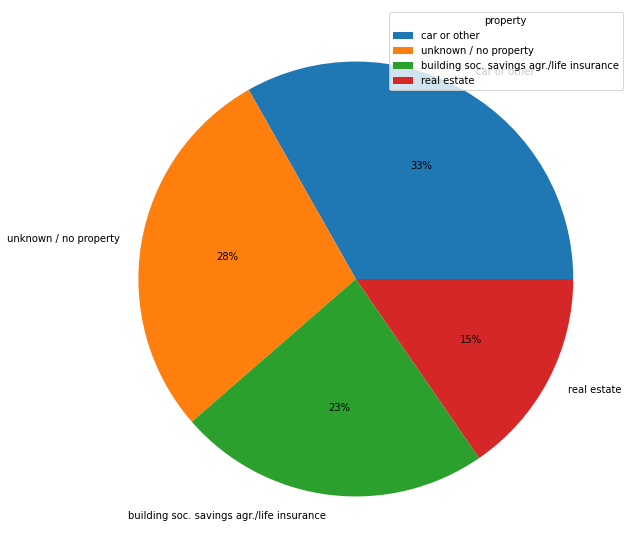

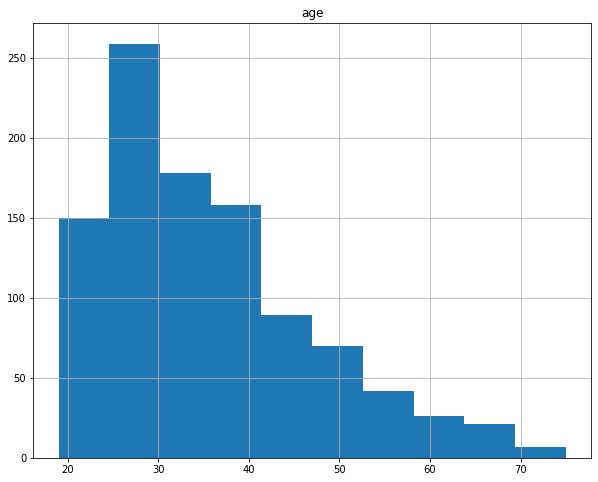

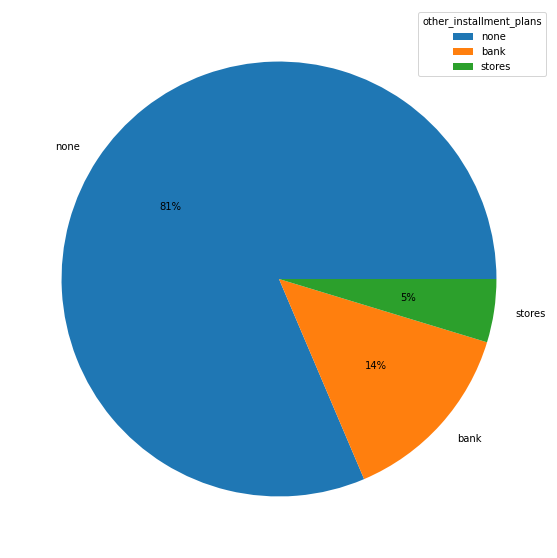

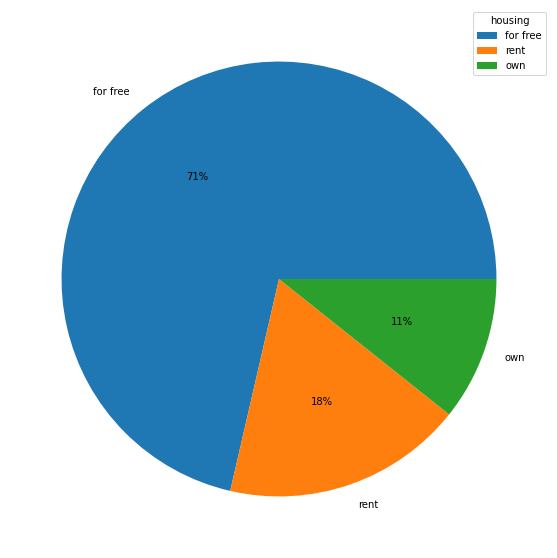

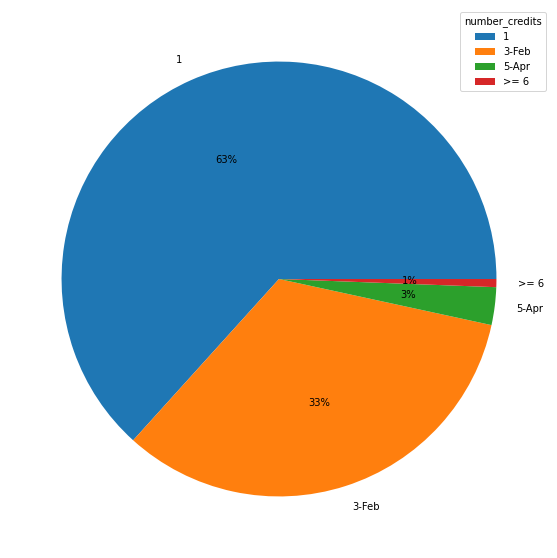

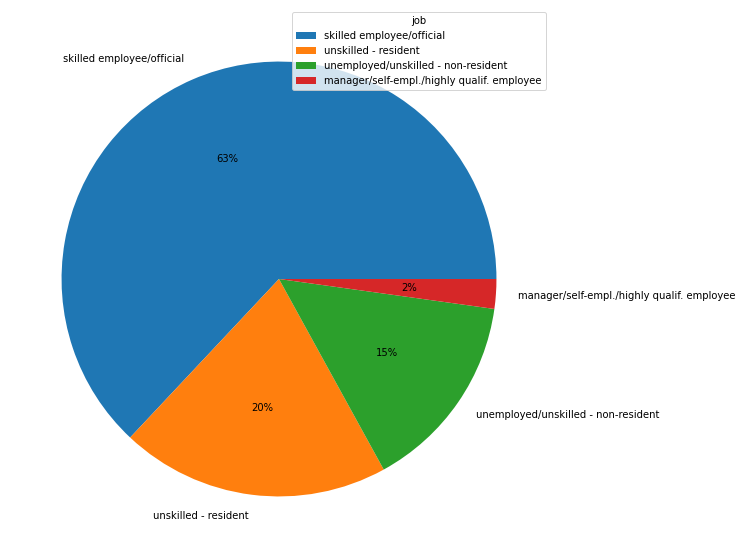

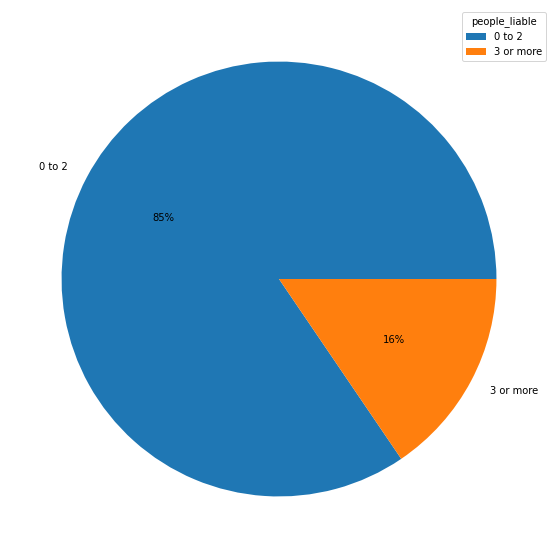

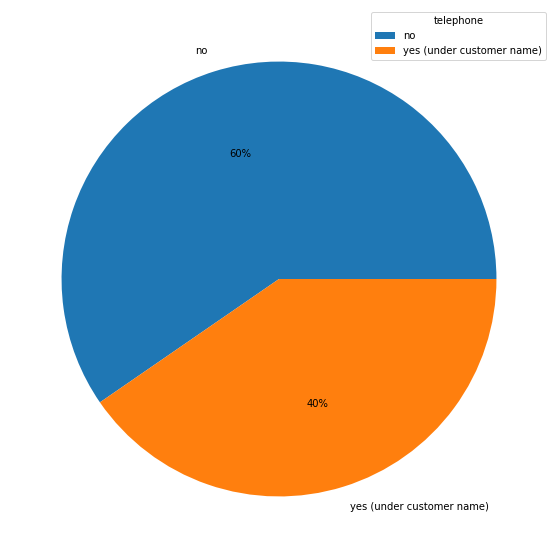

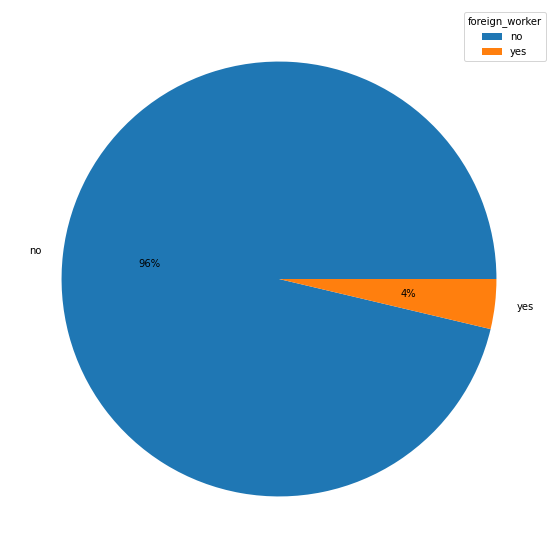

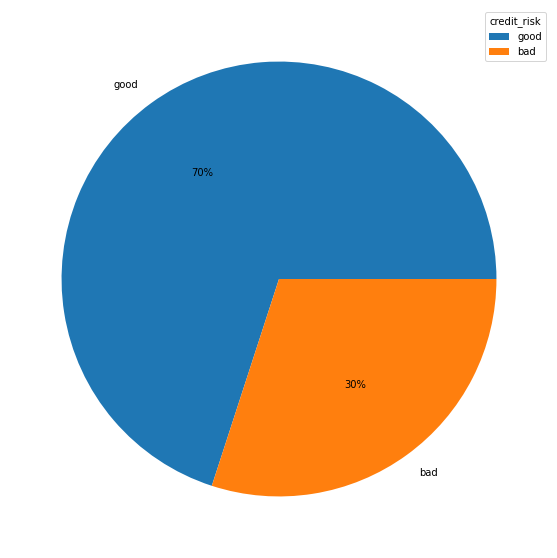

In [139]:
plot_dist(german_bank)

From looking at our categorical values we can see something is weird with the personal_status_sex feature. This feature is a combination of the individuals sex and their martial status. This can definitely can a cause for concern when regarding bias. According to the data dictionary:

A91 : male   : divorced/separated
A92 : female : divorced/separated/married
A93 : male   : single
A94 : male   : married/widowed
A95 : female : single

We can see that from the values the German Bank is coupling divorced and separated men with value A91. The Bank is classifying those two types of men to be the same when qualifying them for credit. This is an assumption the bank has made and given the values of A92, we can see that they view women the same no matter if they are divorced, separated, or currently married. This assumption raises a red flag because classifying these women as the same can create bias when qualifying for credit. 

We can try to mitigate against what the Bank has done with this particular feature, however, we don't have enough information to decouple this issue completely. With that we can already reject our null hypothesis, clearly the Bank has manipulated the data to group by these catgories. We will see later on the implications on this on predicting credit_risk.

### Separating personal_status_sex into gender and marital status

We will try to fix this issue with the personal_status_sex feature by separating into gender and marital status. We can later see how the original dataset performs in comparison to our dataset with bias mitigation changes.

In [140]:
# viewing series
german_bank['personal_status_sex']

0      female : non-single or male : single
1                    male : married/widowed
2      female : non-single or male : single
3                    male : married/widowed
4                    male : married/widowed
                       ...                 
995                  male : married/widowed
996                  male : married/widowed
997                  male : married/widowed
998                  male : married/widowed
999                  male : married/widowed
Name: personal_status_sex, Length: 1000, dtype: object

In [141]:
# defining useful functions

# convert unique values into dict with numerical keys
def get_values_dict(df, column):
    value_dict = {}
    values = df[column].unique()
    for index in range(len(values)):
        value_dict[values[index]] = index
    return value_dict

# convert each item in series based on keys in dict
def convert_cat(item, values_dict):
    return values_dict[item]

# convert series
def convert_column(df, column, values_dict):
    df[column] = df[column].apply(convert_cat, args=(values_dict,))

In [142]:
# convert the all categorical values 
def convert_df(df):
    for col in df.columns:
        if df[col].dtype == "O":
            dict_values = get_values_dict(df, col)
            convert_column(df, col, dict_values)
        else:
            pass


In [143]:
convert_df(german_bank)

In [117]:
personal_status_sex_values = get_values_dict(german_bank,'personal_status_sex')

#personal_status_sex_values
def generate_gender(dict_values):
    keys = dict_values.values()
    for i in keys:
        if i == 1 or i == 3:
            return "male"
        elif i == 2:
            return "female"
        else:
            return "unknown"
        
#personal_status_sex_values
def generate_marital_status(dict_values):
    keys = dict_values.values()
    for i in keys:
        if i == 1 or i == 3:
            return "unknown"
        elif i == 2:
            return "female"
        else:
            return "unknown"        
german_bank['gender'] = german_bank[personal_status_sex].apply(generate_gender, args=(personal_status_sex_values,))     

generate_gender(personal_status_sex_values)

unknown
0
male
1
female
2
male
3


In [118]:
personal_status_sex_values

{'female : non-single or male : single': 0,
 'male : married/widowed': 1,
 'female : single': 2,
 'male : divorced/separated': 3}

In [144]:
# previewing data
german_bank.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0,18,0,0,1049,0,0,0,0,0,...,0,21,0,0,0,0,0,0,0,0
1,0,9,0,1,2799,0,1,1,1,0,...,1,36,0,0,1,0,1,0,0,0
2,1,12,1,2,841,1,2,1,0,0,...,1,23,0,0,0,1,0,0,0,0
3,0,12,0,1,2122,0,1,2,1,0,...,1,39,0,0,1,1,1,0,1,0
4,0,12,0,1,2171,0,1,0,1,0,...,0,38,1,1,1,1,0,0,1,0


In [361]:
german_bank.describe()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.246000,20.903000,1.022000,2.437000,3271.24800,0.970000,1.885000,0.95300,0.882000,0.134000,...,1.408000,35.54200,0.233000,0.928000,0.407000,0.688000,0.155000,0.404000,0.037000,0.300000
std,0.927547,12.058814,0.991211,2.112935,2822.75176,1.353119,1.445636,1.08442,0.767245,0.445244,...,1.007249,11.35267,0.522479,0.530186,0.577654,1.071356,0.362086,0.490943,0.188856,0.458487
min,0.000000,4.000000,0.000000,0.000000,250.00000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,19.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,0.000000,1.000000,1365.50000,0.000000,1.000000,0.00000,0.000000,0.000000,...,1.000000,27.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,18.000000,1.000000,2.000000,2319.50000,0.000000,1.000000,1.00000,1.000000,0.000000,...,1.000000,33.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,24.000000,1.000000,3.000000,3972.25000,2.000000,4.000000,2.00000,1.000000,0.000000,...,2.000000,42.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,3.000000,72.000000,4.000000,9.000000,18424.00000,4.000000,4.000000,3.00000,3.000000,2.000000,...,3.000000,75.00000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [375]:
# independent and dependent vars 13 vars
x = german_bank[['status','duration',
                 'credit_history','purpose',
                 'savings','employment_duration',
                 'installment_rate','personal_status_sex','other_debtors',
                'property','other_installment_plans','housing','number_credits']]
# target variable
y = german_bank['credit_risk']

# creating model and fitting data
model = LogisticRegression(solver='liblinear', random_state=0)
# using 10% for testing and 90% for training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

model.fit(X_scaled, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [376]:
# intercept 
model.intercept_

array([-0.99234043])

In [377]:
# coefficients
model.coef_

array([[ 0.11589464,  0.18597258, -0.16048778,  0.12464691, -0.00848736,
         0.01415476,  0.05128556,  0.06260879,  0.27401407,  0.11381016,
         0.49590479, -0.40899052,  0.34614087]])

In [378]:
model.classes_

array([0, 1])

In [379]:
# coefficient for personal_status_sex
model.coef_.tolist()[0][7]

0.06260878668340998

We can check its performance with .predict_proba(), which returns the matrix of probabilities that the predicted output is equal to zero or one

In [380]:
model.predict_proba(X_train)

array([[3.40213271e-01, 6.59786729e-01],
       [2.16725085e-01, 7.83274915e-01],
       [1.52669841e-01, 8.47330159e-01],
       ...,
       [4.11354556e-02, 9.58864544e-01],
       [4.01244105e-05, 9.99959876e-01],
       [3.12144972e-02, 9.68785503e-01]])

We can get the actual predictions, based on the probability matrix and the values of 𝑝(𝑥), with .predict()

In [381]:
model.predict(X_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [383]:
model.score(X_train, y_train)

0.29777777777777775

.score() takes the input and output as arguments and returns the ratio of the number of correct predictions to the number of observations.

You can get more information on the accuracy of the model with a confusion matrix. In the case of binary classification, the confusion matrix shows the numbers of the following:

True negatives in the upper-left position
False negatives in the lower-left position
False positives in the upper-right position
True positives in the lower-right position

In [384]:
confusion_matrix(y_train, model.predict(X_train))

array([[  5, 630],
       [  2, 263]])

The obtained matrix shows the following:

Three true negative predictions: The first three observations are zeros predicted correctly.
No false negative predictions: These are the ones wrongly predicted as zeros.
One false positive prediction: The fourth observation is a zero that was wrongly predicted as one.
Six true positive predictions: The last six observations are ones predicted correctly.


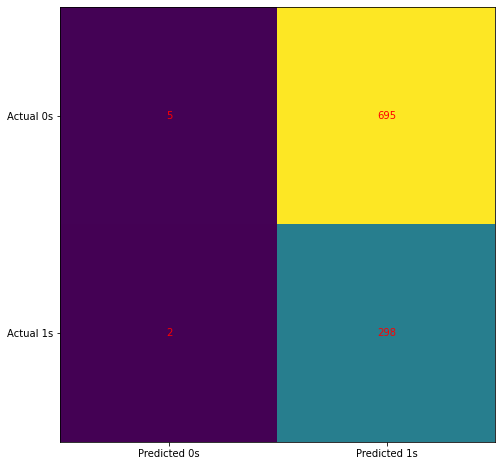

In [385]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
print(classification_report(y_train, model.predict(X_train)))

Are the results of the model fair?